# Introduction of sentence and paragraph features

- This notebook extends previous work shared in the context of this competition: 
    - ["{ENTER}ing the TimeSeries {SPACE} Sec 3 + New Aggs"](https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs) (shared by [Abdullah Meda](https://www.kaggle.com/abdullahmeda))
    - (Not used in newest version of the notebook) ["Essay Contructor"](https://www.kaggle.com/code/kawaiicoderuwu/essay-contructor) (shared by [Kawaii Coder UwU](https://www.kaggle.com/kawaiicoderuwu))
    - ["Fast essay constructor"](https://www.kaggle.com/code/yuriao/fast-essay-constructor) (shared by [yuri-ao](https://www.kaggle.com/yuriao))
- If you find this notebook helpful and decide to upvote it, please also upvote the notebooks mentioned above and the notebooks Abdullah referrences in his notebook:
    - https://www.kaggle.com/code/hengzheng/link-writing-simple-lgbm-baseline
    - https://www.kaggle.com/code/abhranta/lgbm-finetuning-with-optuna
    - https://www.kaggle.com/code/mcpenguin/writing-processes-to-quality-baseline
    - https://www.kaggle.com/code/gopidurgaprasad/youtube-video-writing-quality-lgbm
    - https://www.kaggle.com/code/olyatsimboy/towards-tf-idf-in-logs-features
- **Contribution:** 
    - I used the "getEssays" function implemented in the "Essay Constructor" notebook to construct the essays, split them into sentences and paragraphs, counted characters and words in the sentences and paragraphs, and computed aggregations (e.g., number of sentences, number of paragraphs, mean sentence lengths). 
    - The feature importance plot reveals that some of these features are indeed "important." With the additional features, the notebook's scores improve slightly (e.g., 0.595 to 0.588 Public LB Score).
- **Changelog (only listing versions with "relevant" changes):**
    - Version 16: Used "fast essay constructor" code to construct the essays
    - Version 09: Consideration of words per sentence and paragraph (in addition to characters per sentence and paragraph) (Public LB Score: 0.588)
    - Version 08: Additional aggregations (e.g., quantiles, skew) (Public LB Score: 0.592)
    - Version 05: Additional sentence and paragraph features (Public LB Score: 0.593)

In [1]:
!pip install --no-index -U --find-links=/kaggle/input/lightautoml-038-dependecies lightautoml==0.3.8
!pip install --no-index -U --find-links=/kaggle/input/lightautoml-038-dependecies pandas==2.0.3

Looking in links: /kaggle/input/lightautoml-038-dependecies
Processing /kaggle/input/lightautoml-038-dependecies/lightautoml-0.3.8-py3-none-any.whl
Processing /kaggle/input/lightautoml-038-dependecies/AutoWoE-1.3.2-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/joblib-1.2.0-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/json2html-1.3.0.tar.gz (from lightautoml==0.3.8)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/lightautoml-038-dependecies/lightgbm-3.2.1-py3-none-manylinux1_x86_64.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/poetry_core-1.8.1-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/StrEnum-0.4.15-py3-none-any.whl (from autowoe>=

In [2]:
%matplotlib inline
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import copy

## Load Data

In [3]:
INPUT_DIR = '/kaggle/input/linking-writing-processes-to-writing-quality'
train_logs = pd.read_csv(f'{INPUT_DIR}/train_logs.csv')
train_scores = pd.read_csv(f'{INPUT_DIR}/train_scores.csv')
test_logs = pd.read_csv(f'{INPUT_DIR}/test_logs.csv')
ss_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

In [4]:
train_essays = pd.read_csv('/kaggle/input/writing-quality-challenge-constructed-essays/train_essays_fast.csv')
train_essays.head()

,id,essay
0,001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
1,0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
2,0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
3,0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
4,0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."


## Feature Engineering

In [5]:
# Function to construct essays copied from here (small adjustments): https://www.kaggle.com/code/yuriao/fast-essay-constructor

def processingInputs(currTextInput):
    essayText = ""
    for Input in currTextInput.values:
        # Input[0] = activity
        # Input[1] = cursor_position
        # Input[2] = text_change
        # Input[3] = id
        # If activity = Replace
        if Input[0] == 'Replace':
            # splits text_change at ' => '
            replaceTxt = Input[2].split(' => ')
            essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
            continue

        # If activity = Paste    
        if Input[0] == 'Paste':
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
            continue

        # If activity = Remove/Cut
        if Input[0] == 'Remove/Cut':
            essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
            continue

        # If activity = Move...
        if "M" in Input[0]:
            # Gets rid of the "Move from to" text
            croppedTxt = Input[0][10:]              
            # Splits cropped text by ' To '
            splitTxt = croppedTxt.split(' To ')              
            # Splits split text again by ', ' for each item
            valueArr = [item.split(', ') for item in splitTxt]              
            # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
            moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))
            # Skip if someone manages to activiate this by moving to same place
            if moveData[0] != moveData[2]:
                # Check if they move text forward in essay (they are different)
                if moveData[0] < moveData[2]:
                    essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] +\
                    essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                else:
                    essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] +\
                    essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
            continue                

        # If activity = input
        essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
    return essayText


def getEssays(df):
    # Copy required columns
    textInputDf = copy.deepcopy(df[['id', 'activity', 'cursor_position', 'text_change']])
    # Get rid of text inputs that make no change
    textInputDf = textInputDf[textInputDf.activity != 'Nonproduction']     
    # construct essay, fast 
    tqdm.pandas()
    essay=textInputDf.groupby('id')[['activity','cursor_position', 'text_change']].progress_apply(
        lambda x: processingInputs(x))      
    # to dataframe
    essayFrame=essay.to_frame().reset_index()
    essayFrame.columns=['id','essay']
    # Returns the essay series
    return essayFrame

In [6]:
# Helper functions

def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

In [7]:
AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', q1, 'median', q3, 'skew', pd.DataFrame.kurt, 'sum']

def split_essays_into_sentences(df):
    essay_df = df
    #essay_df['id'] = essay_df.index
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    essay_df = essay_df.explode('sent')
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.sent_len!=0].reset_index(drop=True)
    return essay_df

def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def split_essays_into_paragraphs(df):
    essay_df = df
    #essay_df['id'] = essay_df.index
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: x.split('\n'))
    essay_df = essay_df.explode('paragraph')
    # Number of characters in paragraphs
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
    return essay_df

def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    ) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

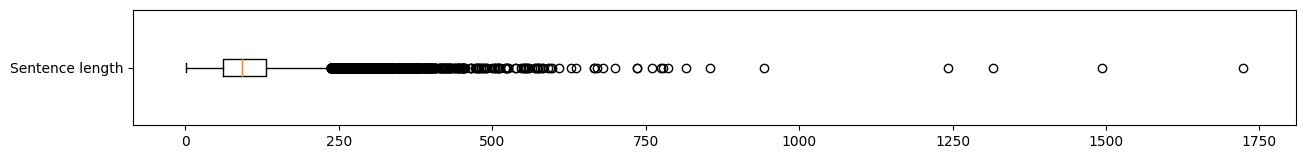

In [8]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essays)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)
plt.figure(figsize=(15, 1.5))
plt.boxplot(x=train_sent_df.sent_len, vert=False, labels=['Sentence length'])
plt.show()

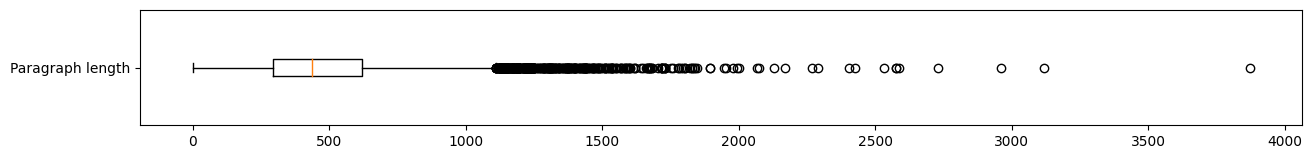

In [9]:
# Paragraph features for train dataset
train_paragraph_df = split_essays_into_paragraphs(train_essays)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)
plt.figure(figsize=(15, 1.5))
plt.boxplot(x=train_paragraph_df.paragraph_len, vert=False, labels=['Paragraph length'])
plt.show()

In [10]:
# Features for test dataset
test_essays = getEssays(test_logs)
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essays))
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essays))

100%|██████████| 3/3 [00:00<00:00, 1245.83it/s]


In [11]:
# The following code comes almost Abdullah's notebook: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Abdullah's code is based on work shared in previous notebooks (e.g., https://www.kaggle.com/code/hengzheng/link-writing-simple-lgbm-baseline)

from collections import defaultdict

class Preprocessor:
    
    def __init__(self, seed):
        self.seed = seed
        
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        
        self.idf = defaultdict(float)
    
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
            
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df
    
    def make_feats(self, df):
        
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})
        
        print("Engineering time data")
        for gap in self.gaps:
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering cursor position data")
        for gap in self.gaps:
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering word count data")
        for gap in self.gaps:
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)
        
        print("Engineering statistical summaries for features")
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt])
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']

        return feats

In [12]:
preprocessor = Preprocessor(seed=42)
train_feats = preprocessor.make_feats(train_logs)
test_feats = preprocessor.make_feats(test_logs)
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)
test_feats = test_feats.drop(columns=nan_cols)

Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [04:18<00:00,  7.83s/it, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 4823.48it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 4498.95it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 2471/2471 [00:00<00:00, 4316.26it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 4616.19it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 4672.21it/s]


Engineering input words data


/tmp/ipykernel_32/3946551957.py:221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
/tmp/ipykernel_32/3946551957.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
/tmp/ipykernel_32/3946551957.py:223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

Engineering ratios data
Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [00:06<00:00,  5.18it/s, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 3/3 [00:00<00:00, 4626.07it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 3/3 [00:00<00:00, 13472.07it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 3/3 [00:00<00:00, 2290.30it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 3/3 [00:00<00:00, 2172.84it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<00:00, 9496.54it/s]


Engineering input words data
Engineering ratios data


/tmp/ipykernel_32/3946551957.py:221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
/tmp/ipykernel_32/3946551957.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
/tmp/ipykernel_32/3946551957.py:223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

In [13]:
# Code for additional aggregations comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs

train_agg_fe_df = train_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

test_agg_fe_df = test_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')
test_feats = test_feats.merge(test_agg_fe_df, on='id', how='left')

In [14]:
# Code for creating these features comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf

data = []

for logs in [train_logs, test_logs]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores, on='id', how='left')

In [15]:
# Adding the additional features to the original feature set

train_feats = train_feats.merge(train_sent_agg_df, on='id', how='left')
train_feats = train_feats.merge(train_paragraph_agg_df, on='id', how='left')
test_feats = test_feats.merge(test_sent_agg_df, on='id', how='left')
test_feats = test_feats.merge(test_paragraph_agg_df, on='id', how='left')

In [16]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

## LightGBM train and predict

In [17]:
OOF_PREDS = np.zeros((len(train_feats), 2))
TEST_PREDS = np.zeros((len(test_feats), 2))

In [18]:
# Code comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs

models_dict = {}
scores = []

test_predict_list = []
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18,
               'n_jobs':4
              }

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            **best_params
        }
        model = lgb.LGBMRegressor(**params)
        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )
        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict
        OOF_PREDS[valid_idx, 0] += valid_predict / 5
        test_predict = model.predict(X_test)
        TEST_PREDS[:, 0] += test_predict / 5 / 10
        test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

[1]	valid_0's rmse: 0.99575
[2]	valid_0's rmse: 0.973232
[3]	valid_0's rmse: 0.953119
[4]	valid_0's rmse: 0.934214
[5]	valid_0's rmse: 0.915742
[6]	valid_0's rmse: 0.898875
[7]	valid_0's rmse: 0.882403
[8]	valid_0's rmse: 0.866766
[9]	valid_0's rmse: 0.851229
[10]	valid_0's rmse: 0.837735
[11]	valid_0's rmse: 0.824618
[12]	valid_0's rmse: 0.811395
[13]	valid_0's rmse: 0.799511
[14]	valid_0's rmse: 0.788062
[15]	valid_0's rmse: 0.776811
[16]	valid_0's rmse: 0.76569
[17]	valid_0's rmse: 0.756567
[18]	valid_0's rmse: 0.748803
[19]	valid_0's rmse: 0.739986
[20]	valid_0's rmse: 0.731641
[21]	valid_0's rmse: 0.724825
[22]	valid_0's rmse: 0.716858
[23]	valid_0's rmse: 0.710321
[24]	valid_0's rmse: 0.704817
[25]	valid_0's rmse: 0.699002
[26]	valid_0's rmse: 0.694314
[27]	valid_0's rmse: 0.688939
[28]	valid_0's rmse: 0.684362
[29]	valid_0's rmse: 0.67926
[30]	valid_0's rmse: 0.674761
[31]	valid_0's rmse: 0.669703
[32]	valid_0's rmse: 0.665845
[33]	valid_0's rmse: 0.661903
[34]	valid_0's rmse: 0

In [19]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], OOF_PREDS[:, 0], squared=False)))

OOF metric LGBM = 0.61586


## LightAutoML NN (DenseLight) prediction

In [20]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import joblib

In [21]:
for i in range(3):
    oof_pred, automl = joblib.load('/kaggle/input/linkinglamamodels/oof_and_lama_denselight_{}.pkl'.format(i))
    OOF_PREDS[:, 1] += oof_pred / 3
    TEST_PREDS[:, 1] += automl.predict(test_feats[train_cols]).data[:, 0] / 3

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your o

In [22]:
print('OOF metric LightAutoML_NN = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], OOF_PREDS[:, 1], squared=False)))

OOF metric LightAutoML_NN = 0.61386


## Blending

In [23]:
best_sc = 1
for w in np.arange(0, 1.01, 0.001):
    sc = metrics.mean_squared_error(train_feats[target_col], 
                                    w * OOF_PREDS[:, 0] + (1-w) * OOF_PREDS[:, 1], 
                                    squared=False)
    if sc < best_sc:
        best_sc = sc
        best_w = w
        
print('Composition OOF score = {:.5f}'.format(best_sc))
print('Composition best W = {:.3f}'.format(best_w))

Composition OOF score = 0.60878
Composition best W = 0.458


## Submission creation

In [24]:
W = [best_w, 1 - best_w]
test_preds = TEST_PREDS[:, 0] * W[0] + TEST_PREDS[:, 1] * W[1]
test_preds

array([1.69126068, 0.99497243, 0.95962394])

In [25]:
test_feats['score'] = test_preds
test_feats[['id', 'score']].to_csv("submission.csv", index=False)

/tmp/ipykernel_32/489633246.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_feats['score'] = test_preds


In [26]:
test_feats[['id', 'score']]

,id,score
0,0000aaaa,1.691261
1,2222bbbb,0.994972
2,4444cccc,0.959624
